In [1]:
from capstone_data_eng import *
import seaborn as sns
import statsmodels.api as sm

### Library versions

#### Tested environment

```
pandas:  0.24.2
sklearn:  0.21.2
statsmodels:  0.9.0
```



In [2]:
import pandas as pd
import sklearn
import statsmodels

print('pandas: ',pd.__version__)
print('sklearn: ',sklearn.__version__)
print('statsmodels: ',statsmodels.__version__)



pandas:  0.24.2
sklearn:  0.21.2
statsmodels:  0.9.0


## Load the data 

In [3]:
out, profile_all, portfolio, offers_all, transactions_all, transactions_during_offer, transactions_outside_offer = load_data_cv(
        person_split=None, rename_offers=True, time_split_min=None, time_split_max=None,
        add_transactions=False, skip_overlap=False, skip_add_purchases=False, calc_net_offer_time=True,
        assign_to='ignore', location='local')

c:\X\ML\Starbucks_capstone\capstone_data_eng.py:741: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  profile_all = load_profile(location=location)


offer received     76277
offer viewed       57725
offer completed    33579
Name: event, dtype: int64
er,ec,ev
(76277, 3) (33579, 4) (57725, 3)
er  (76277, 6)
persons with no offers received in timeframe:  6
transactions_during_offer.shape: (122652, 7)
(76277, 27)
add_stats_by_person:
(76277, 38)
(76277, 44)
(76277, 50)
(76277, 51)
(76277, 60)


## Utility functions

In [ ]:
def percentage_true_by(df,by,column):
    # returns the percentage of true value in dataframe df grouped by by
    
    ratio_true_false=df.groupby(by=by)[column].value_counts(normalize=True)
    percentage_true=ratio_true_false.loc[ratio_true_false.index.get_level_values(column)==True,:]
    percentage_true=100.*percentage_true.droplevel(level=column)
    return(percentage_true)
    

# Feature engineering

In [4]:
out.columns

Index(['person', 'offer', 'offer_received', 'offer_viewed', 'offer_completed',
       'reward', 'offer_end', 'difficulty', 'duration', 'offer_type', 'web',
       'email', 'mobile', 'social', 'offer_reward', 'duration_hours',
       'duration_viewed', 'duration_effective', 'viewed', 'rewarded',
       'received', 'comp_not_viewed', 'completed', 'Tpay_offer', 'Npay_offer',
       'Maxpay_offer', 'Minpay_offer', 'Netpay_offer', 'Avg_pay_offer', 'age',
       'became_member_on', 'gender', 'income', 'joined_year', 'joined_month',
       'joined_week', 'gender_num', 'user_time', 'Tpay_out', 'Npay_out',
       'p_c_r_ratio', 'p_cnv_r_ratio', 'p_c_v_ratio', 'overlaps',
       'Tpay_offers_tot', 'Npay_offers_tot', 'Maxpay_offers_tot',
       'Minpay_offers_tot', 'Trewards_tot', 'Nrewards_tot',
       'tot_gross_offer_time', 'tot_net_offers_time', 'tot_not_offers_time',
       'Avg_pay_offers', 'Net_pay_offers', 'Avg_net_pay_offers',
       'Avg_pay_outside', 'Avg_D_O', 'Avg_D_OS', 'Avg_D_nOS']

In [149]:
out['binned_income'] = pd.cut(out['income'],bins= np.arange(0,14)*1e4,labels=np.arange(0,13)*10)
out['binned_age'] = pd.cut(out['age'],bins= np.arange(0,120,10) ,labels=np.arange(0,120,10)[:-1])

In [ ]:
c_drop=['person','offer', 'became_member_on',]

c_bin=['web', 'email', 'mobile', 'social','viewed', 'rewarded',
       'received', 'comp_not_viewed', 'completed']

c_num_time=['offer_received', 'offer_viewed', 'offer_completed', 'offer_end']
c_num_offer=['reward','difficulty', 'duration', 'offer_reward', 'duration_hours',
       'duration_viewed', 'duration_effective', 'overlaps',]
c_num_offer_leak=['Tpay_offer', 'Npay_offer','Maxpay_offer', 'Minpay_offer', 
                  'Netpay_offer', 'Avg_pay_offer', 'income', 'joined_year', 'joined_month',
       'joined_week', 'gender_num', 'user_time',  'p_c_r_ratio', 'p_cnv_r_ratio', 'p_c_v_ratio' ]
c_num_offers_leak=['Tpay_offers_tot', 'Npay_offers_tot', 'Maxpay_offers_tot',
       'Minpay_offers_tot', 'Trewards_tot', 'Nrewards_tot',
       'tot_gross_offer_time', 'tot_net_offers_time', 'tot_not_offers_time',
       'Avg_pay_offers', 'Net_pay_offers', 'Avg_net_pay_offers',
       'Avg_pay_outside', 'Avg_D_O', 'Avg_D_OS', 'Avg_D_nOS']


c_cat_offer=['offer_type', ]
c_num_person=['age', 'Tpay_out', 'Npay_out', ]
c_cat_person=['gender',]



c_all=c_drop+c_bin+c_num_time+c_num_offer+c_num_offer_leak+c_num_offers_leak +\
  c_cat_offer+c_num_person+c_cat_person

In [ ]:
print('missing columns from out / c_all')
print( set(out.columns ) ^ set(c_all) )

missing columns from out / c_all
set()


In [ ]:
out.loc[out.gender.isna(),'gender']='M'
out.loc[out.income.isna(),'income']=out.income.median()
out[['offer_viewed', 'offer_completed']]=out[['offer_viewed', 'offer_completed']].fillna(-1)

In [ ]:
print("columns with nans", list( out.columns[out.isna().any()] ))

columns with nans []


# 1) EDA: Offers

The database 'portfolio' is used as it is except for:
* renaming the hash-id to a shorthand (a,b,c,d...) to simplify plotting
* separating the channel column into separate web, email, mobile, social columns.


The entirety of the database is shown below:

In [5]:
display(portfolio)

,difficulty,duration,offer,offer_type,offer_reward,web,email,mobile,social,duration_hours
0,10,7,h,bogo,10,False,True,True,True,168.0
1,10,5,e,bogo,10,True,True,True,True,120.0
2,0,4,d,informational,0,True,True,True,False,96.0
3,5,7,g,bogo,5,True,True,True,False,168.0
4,20,10,a,discount,5,True,True,False,False,240.0
5,7,7,b,discount,3,True,True,True,True,168.0
6,10,10,j,discount,2,True,True,True,True,240.0
7,0,3,f,informational,0,False,True,True,True,72.0
8,5,5,i,bogo,5,True,True,True,True,120.0
9,10,7,c,discount,2,True,True,True,False,168.0


## 1.1) How are offers sent?

With a few visualizations we observe that offers are sent in bulk 7 times at the same date and hour.
Most important offers are overlapping, which means that a bit of data engineering is needed to attribute the purchases to the specific offer.

However, we note that at each sending period an equal amount of offers of each type is sent out.



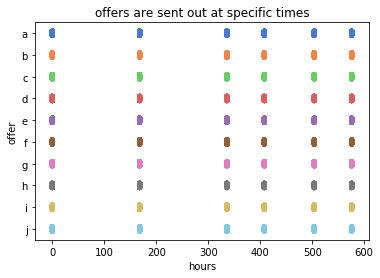

In [129]:
sns.stripplot(y="offer", x="offer_received", data=out.sort_values(by=['offer']),jitter=True);
plt.title('offers are sent out at specific times');
sns.set_palette('muted',10)
plt.xlabel('hours');

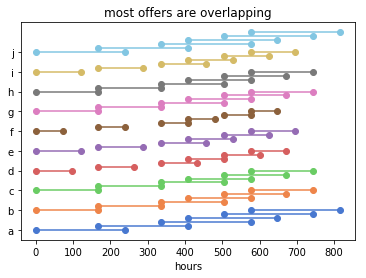

In [130]:
po=out.groupby(by=['offer','offer_received'])[['offer_end']].agg('mean').reset_index();
sns.set_palette('muted',10)

start_times=np.unique(po['offer_received'])
po['offer_num']=po.offer.astype('category').cat.codes

c=0
for start in start_times:
    xx=po.loc[po.offer_received==start,['offer_received','offer_end']].values
    yy=po.loc[po.offer_received==start,['offer_num','offer_num']].values

    plt.plot(xx.T, yy.T+c,'o-',alpha=1);
    c+=0.2
plt.yticks(range(0,10),['a', 'b', 'c', 'd', 'e' ,'f', 'g', 'h', 'i', 'j']);
plt.title('most offers are overlapping');
plt.xlabel('hours');

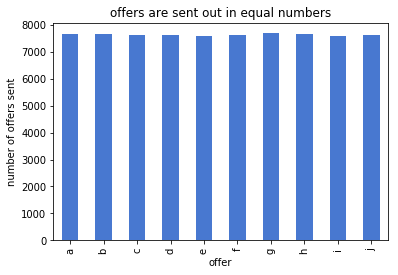

In [134]:
out.groupby(by='offer')['received'].count().plot(kind='bar')
plt.ylabel('number of offers sent');

plt.title('offers of different types are sent out in equal numbers');

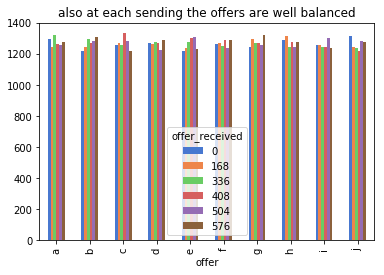

In [142]:
plt.figure(figsize=(14,5));
out.groupby(by=['offer','offer_received'])['received'].count().unstack().plot(kind='bar');
plt.title('also at each sending the offers are well balanced');

## 1.2 Which offer features affect the completion rate?

We define the completion rate CR as:

$$ CR= \frac{completed}{received}$$ 

And the viewed completion rate as VCR:

$$ VCR= \frac{completed}{viewed}$$ 





In [172]:
out['viewed_and_completed']=(out['completed'] & out['viewed'] )

In [9]:
def percentage_true_by(df,by,column):
    # returns the percentage of true value in dataframe df grouped by by
    
    ratio_true_false=df.groupby(by=by)[column].value_counts(normalize=True)
    percentage_true=ratio_true_false.loc[ratio_true_false.index.get_level_values(column)==True,:]
    percentage_true=100.*percentage_true.droplevel(level=column)
    return(percentage_true)
    

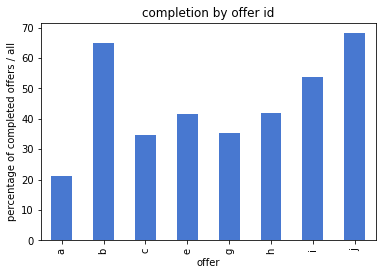

In [164]:
completed=percentage_true_by(out,'offer','completed')
completed.plot(kind='bar')
plt.ylabel('percentage of completed offers / all');
plt.title('completion by offer id');

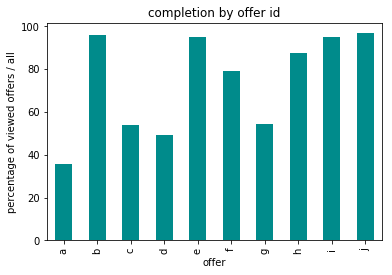

In [168]:
viewed=percentage_true_by(out,'offer','viewed')
viewed.plot(kind='bar',color='darkcyan')
plt.ylabel('percentage of viewed offers / all');
plt.title('completion by offer id');

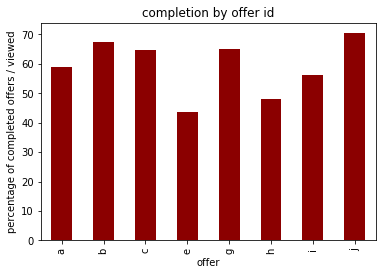

In [181]:
percentage_true_by(out.loc[out.viewed],'offer','viewed_and_completed').plot(kind='bar',color='darkred')
plt.ylabel('percentage of completed offers / viewed');
plt.title('completion by offer id');

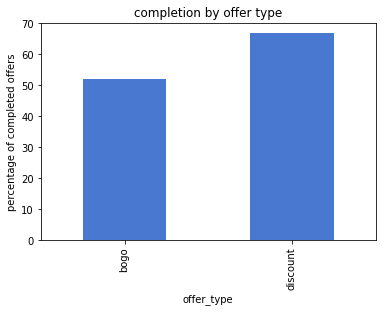

In [183]:
# percentage_true_by(out,'offer_type','completed').plot(kind='bar')
percentage_true_by(out.loc[out.viewed],'offer_type','viewed_and_completed').plot(kind='bar')
plt.ylabel('percentage of completed offers');
plt.title('completion by offer type');

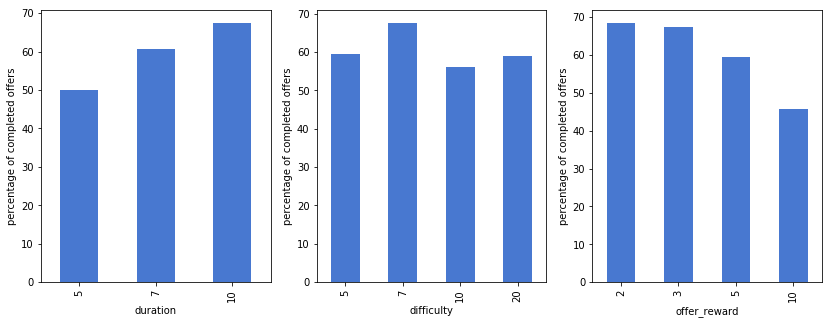

In [184]:
plt.figure(figsize=(14,5))

plt.subplot(131);
percentage_true_by(out.loc[out.viewed],'duration','viewed_and_completed').plot(kind='bar')
plt.ylabel('percentage of completed offers');

plt.subplot(132);
percentage_true_by(out.loc[out.viewed],'difficulty','viewed_and_completed').plot(kind='bar')
plt.ylabel('percentage of completed offers');

plt.subplot(133);
percentage_true_by(out.loc[out.viewed],'offer_reward','viewed_and_completed').plot(kind='bar')
plt.ylabel('percentage of completed offers');

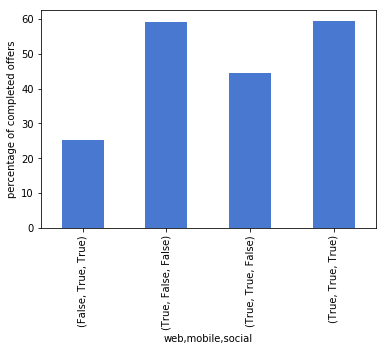

In [186]:
# percentage_true_by(out,['web','mobile','social'],'completed').plot(kind='bar')
percentage_true_by(out.loc[out.viewed],['web','mobile','social'],'viewed_and_completed').plot(kind='bar')
plt.ylabel('percentage of completed offers');

#### Factor interation

The plots below show that:
* the BOGO offer is rather insensitive to difficult, reward, and duration
* the discount offer shows dependence on difficult, reward, and duration but without a clear trend (it is possible that other factors play an important role)



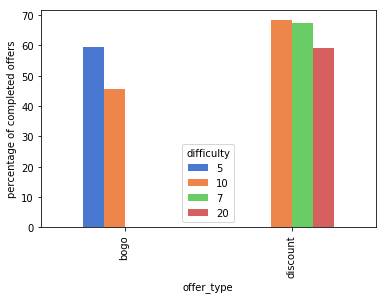

In [198]:
# percentage_true_by(out,['offer_type','difficulty'],'completed').unstack().plot(kind='bar')
percentage_true_by(out.loc[out.viewed],['offer_type','difficulty'],'viewed_and_completed').unstack().plot(kind='bar')
plt.ylabel('percentage of completed offers');

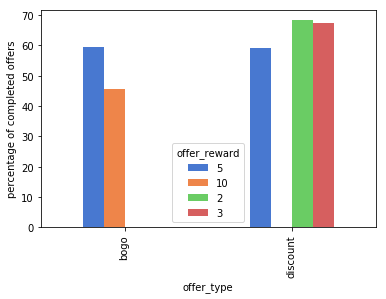

In [200]:
# percentage_true_by(out,['offer_type','offer_reward'],'completed').unstack().plot(kind='bar')
percentage_true_by(out.loc[out.viewed],['offer_type','offer_reward'],'viewed_and_completed').unstack().plot(kind='bar')
plt.ylabel('percentage of completed offers');

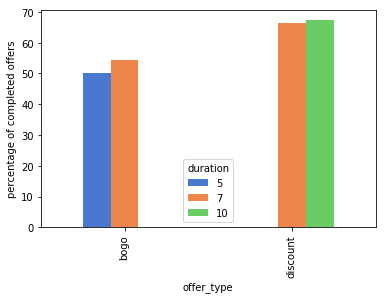

In [201]:
# percentage_true_by(out,['offer_type','duration'],'completed').unstack().plot(kind='bar')
percentage_true_by(out.loc[out.viewed],['offer_type','duration'],'viewed_and_completed').unstack().plot(kind='bar')
plt.ylabel('percentage of completed offers');

Text(0.5,1,'Completed = viewed and completed/viewed')

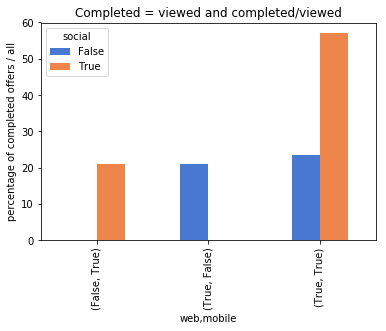

In [221]:
percentage_true_by(out,['web','mobile','social'],'completed').unstack().plot(kind='bar');
plt.ylabel('percentage of completed offers / all');
plt.title('Completed = viewed and completed/viewed')

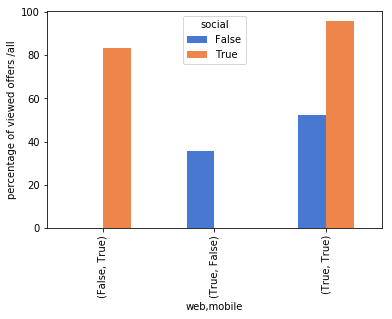

In [222]:
percentage_true_by(out,['web','mobile','social'],'viewed').unstack().plot(kind='bar')
plt.ylabel('percentage of viewed offers /all');


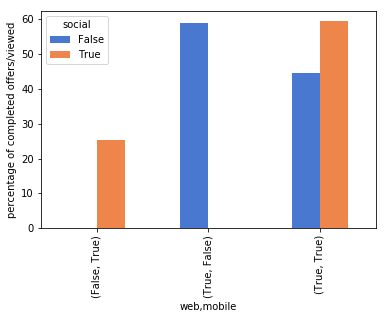

In [224]:
percentage_true_by(out.loc[out.viewed],['web','mobile','social'],'viewed_and_completed').unstack().plot(kind='bar')
plt.ylabel('percentage of completed offers/viewed');

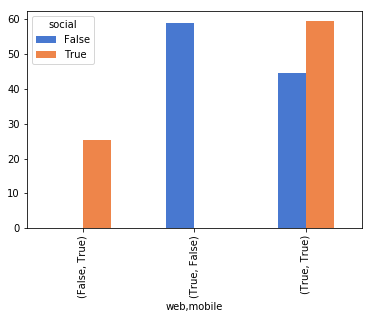

In [208]:
percentage_true_by(out.loc[out.viewed],['web','mobile','social'],'viewed_and_completed').unstack().plot(kind='bar')

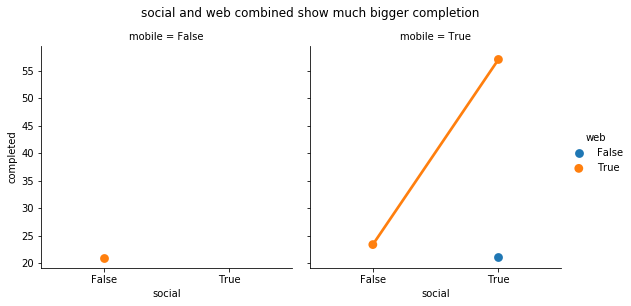

In [64]:
pt=percentage_true_by(out,['web','mobile','social'],'completed').reset_index()
sns.catplot(x="social", y="completed", hue="web",data=pt,kind="point",col='mobile',height=4,marker=['o'],markersize=100,linestyle='--');
plt.suptitle('social and web combined show much bigger completion',y=1.05);


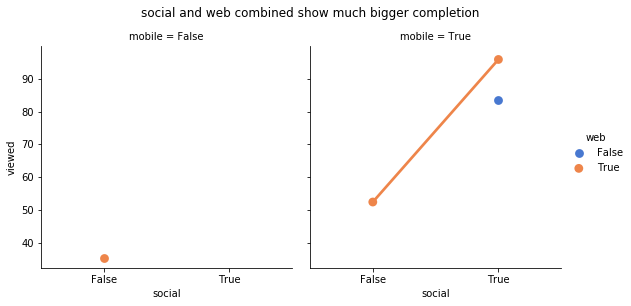

In [228]:
pt=percentage_true_by(out,['web','mobile','social'],'viewed').reset_index()
sns.catplot(x="social", y="viewed", hue="web",data=pt,kind="point",col='mobile',height=4,marker=['o'],markersize=100,linestyle='--');
plt.suptitle('social and web combined show much bigger completion',y=1.05);

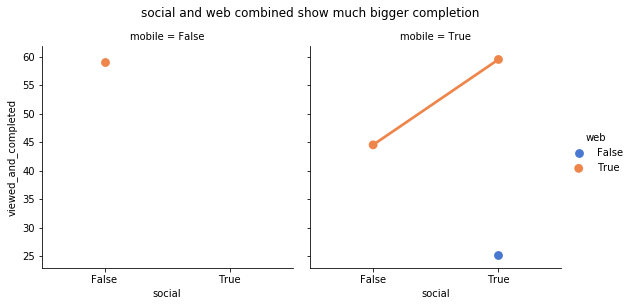

In [227]:
pt=percentage_true_by(out.loc[out.viewed],['web','mobile','social'],'viewed_and_completed').reset_index()
sns.catplot(x="social", y="viewed_and_completed", hue="web",data=pt,kind="point",col='mobile',height=4,marker=['o'],markersize=100,linestyle='--');
plt.suptitle('social and web combined show much bigger completion',y=1.05);

The interaction between social and web affects the view rate, which eventually affects the CR rate but also to a smaller extent the VCR rate.

We create new features and test if they show some trends.

In [229]:
out['web_social']=out['web'] & out['social']
out['difficulty_duration_ratio']=out['difficulty']/out['duration']

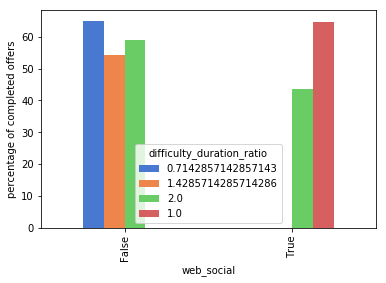

In [230]:
percentage_true_by(out.loc[out.viewed],['web_social','difficulty_duration_ratio'],'viewed_and_completed').unstack().plot(kind='bar')
plt.ylabel('percentage of completed offers');

## 1.3) View time ratios

Some offers are viewed very late (i.e. for 10% of the duration), but in general offers are viewed for most of the time.

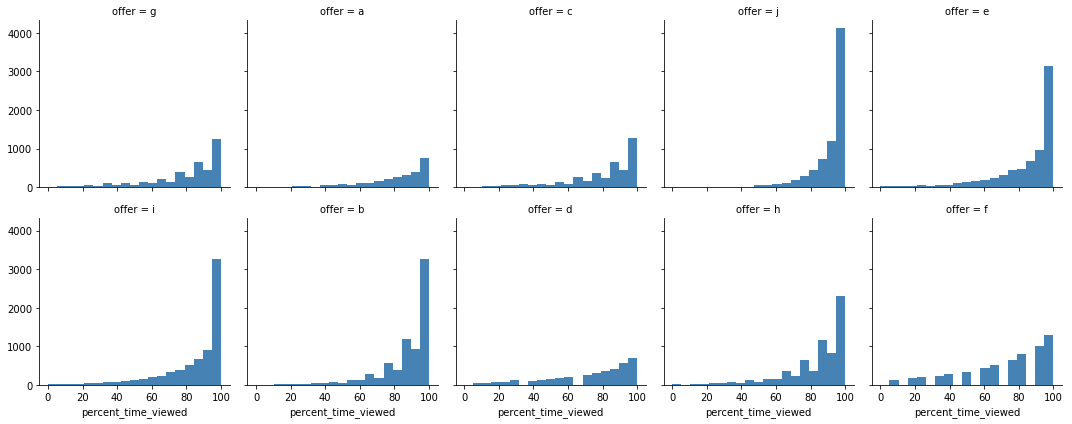

In [235]:
out['percent_time_viewed']=100*out['duration_effective']/out['duration_hours']

g = sns.FacetGrid(out.loc[out.viewed], col="offer",  margin_titles=True, col_wrap=5)
bins = np.linspace(0, 100,20)
g.map(plt.hist, 'percent_time_viewed', color="steelblue", bins=bins)

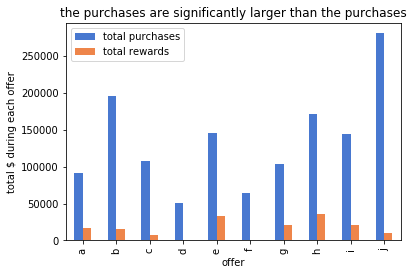

In [238]:
out.groupby(by='offer')['Tpay_offer','reward'].sum().plot(kind='bar')
plt.ylabel('total $ during each offer');
plt.legend(['total purchases','total rewards' ]);
plt.title('the purchases are significantly larger than the purchases');

## 1.4) Discussion

While it's far to early to draw conclusions, the following features of the problem have been identified:
* offers overlaps needs to be addressed in data cleaning
* web and social features show positive interaction 

